<span style="color:springgreen">Корнеев Роман Александрович</span>

<span style = "color:springgreen"> М80-304Б-17 </span>

<h1><center>Лабораторная работа №2</center></h1>

## Реализации

In [1]:
import numpy as np

In [2]:
def Accuracy(Y_val, Y_pred):
    TP = (Y_val * Y_pred).sum()
    TN = np.logical_not(Y_val | Y_pred).sum()
    return (TP + TN) / len(Y_val)

### Логистическая регрессия

In [3]:
def L2_norm(vector):
    return (vector**2).sum()

def L1_norm(vector):
    return np.abs(vec).sum()

def L2_grad(vector):
    return vector

def L1_grad(vector):
    return vector / np.abs(vector)

In [4]:
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

def logit_loss(wx, y_real):
    return np.log(1.0 + np.exp(-wx*y_real)).sum()

def logit_grad(x, y, w):
    koeff = (y * sigmoid(-y*x.dot(w)))
    koeff = koeff.reshape((koeff.shape[0], 1)) # make a column
    return -(koeff * x).sum(axis = 0) # full gradient - sum of gradients on ever x[i]

In [5]:
class GradientDescent:
    def __init__(self, speed, gradient_func, regulasator=None, 
                 C=10.0, eps = 0.001, maxsteps=250):
        self.speed = speed
        self.function = gradient_func
        self.maxsteps = maxsteps
        self.eps = eps
        self.w = None
        if regulasator == "l1":
            self.regulasator = lambda w:  L1_grad(w) / C
        elif regulasator == "l2":
            self.regulasator = lambda w: L2_grad(w) / C
        else:
            self.regulasator = lambda w: 0.0
    
    def fit(self, X_train, Y_train):
        # init w0
        w0 = np.zeros(X_train.shape[1])
        w = np.random.random(X_train.shape[1])
        k = 1
        while np.linalg.norm(w - w0) > self.eps and k <= self.maxsteps:
            w0 = w
            temp = self.speed * ((1 / k)**0.5) # like vowpal step temp
            w = w - temp*(self.function(X_train, Y_train, w) + self.regulasator(w))
            k += 1
        self.w = w
        return w
    
    def get_weights(self):
        return self.w

In [6]:
class CustomLogisticRegression:
    # main params
    def __init__(self, speed = 1, reg_type=None, C=0.5, eps=0.001, maxsteps=2000):
        # init solver
        self.solver = GradientDescent(speed, logit_grad, reg_type, C, eps, maxsteps)
        # init weight  variable
        self.w = None
        
    # training
    def fit(self, X_train, Y_train):
        # convert 0 to -1 for algo
        Y = np.array(Y_train)
        Y[Y_train == 0] = -1
        # add np.ones colomn for w0 weight:
        x0 = np.ones((X_train.shape[0], 1))
        X = np.hstack((x0, X_train))
        # train weight by gradient descent
        self.w = self.solver.fit(X, Y)
        return self
    
    # returns predictes classes
    def predict(self, X_val, border = 0):
        # add np.ones colomn for w0 weight:
        x0 = np.ones((X_val.shape[0], 1))
        X = np.hstack((x0, X_val))
        # <w, x> product for all examples
        Xw = X.dot(self.w)
        # make predict: 0 - negative, 1 - positive
        Y_pred = np.zeros(Xw.shape).astype(np.int8)
        # a(x) = [<w,x> > t], t - border
        Y_pred[Xw >= border] = 1
        return Y_pred
    
    # probs of positive class
    def predict_proba(self, X_val):
        # add np.ones colomn for w0 weight:
        x0 = np.ones((X_val.shape[0], 1))
        X = np.hstack((x0, X_val))
        # <w, x> product for all examples
        Xw = X.dot(self.w)
        # return proba
        return sigmoid(Xw)
    
    # compute metrics
    def score(self, X_val, Y_val, metric=Accuracy):
        return metric(Y_val, self.predict(X_val))
    
    def weights(self):
        return self.w

    # for fun
    def __str__(self):
        return "Logistic Regression model with gradient descent!"
    
    def __repr__(self):
        return "Logistic Regression"

### K Ближайших соседей

In [7]:
def minkovski(x1, x2, p = 3):
    return (np.abs(x1 - x2) ** p).T.sum(axis = 0)**(1.0 / p)

def euclid(x1, x2):
    return minkovski(x1, x2, 2)

In [8]:
def biquadratical_kernel(t):
    return (-t**2 + 1)**2

def triquadratical_kernel(t):
    return (-t**2 + 1)**3
    
def triqubical_kernel(t):
    return (-t**3 + 1)**3

In [9]:
# stay parsen kerel None for simple KNN algo
class CustomKNN:
    def __init__(self, k = 5, metric = euclid, parsen_kernel = None):
        self.k = k
        self.p = metric
        # algo shoud remember all data
        self.X = None
        self.Y = None
        if parsen_kernel is None:
            # all elems have equal weight
            self.Kp = lambda t: 1.0
        else:
            # parsen method
            self.Kp = parsen_kernel
    
    def fit(self, X_train, Y_train):
        # just remmember data:
        self.X = X_train
        self.Y = Y_train
        # check correct of k
        self.k = min(self.k, len(self.Y) - 1)
        return self

    def predict(self, X_val):
        Y_pred = np.zeros(len(X_val)).astype(np.int8)
        # for each elem in X predict result:
        for i in np.arange(len(X_val)):
            Y_pred[i] = self.predict_one(X_val[i])
        return Y_pred

    def predict_one(self, x):
        # compute all distances
        r_x = self.p(self.X, x)
        # take sorted order of dists in idxs
        order = np.argsort(r_x)
        # width for parsen is distance to k+1 neiborh:
        h = r_x[order[self.k]]
        # idxs of first k elems neibrh
        order = order[:self.k]
        # take first k Y:
        Y_k = self.Y[order]
        # compute parsen function for all neiborh:
        K = self.Kp(r_x[order] / h)
        
        # compute functional for positives elems
        pos_w = (K * Y_k).sum()
        # compute functional for negatives elems
        neg_w = (K * np.logical_not(Y_k)).sum()
        
        # class with more functional wins
        return int(pos_w > neg_w) # 0 or 1


    def score(self, X_val, Y_val, metric=Accuracy):
        return metric(Y_val, self.predict(X_val))

    def __str__(self):
        return "k Nearest Neighbor"

    def __repr__(self):
        return "KNN"

### Решающее дерево

In [10]:
def bingini(*args):
    # for binary classification: p(-) = 1 - p(+)=>
    # Gini = 2 * p(+) * (1 - p(+))
    if len(args) == 2:
        p = args[0] / (args[1]+args[0])
    else:
        p = args[0].sum() / args[0].shape[0]
    return 2 * p * (1 - p)

def binentropy(*args):
    # for binary classification: p(-) = 1 - p(+)=>
    # Entropy = -p(+)log(p(+)) - (1 - p(+))log(1 - p(+))
    if len(args) == 2:
        p = args[0] / (args[1]+args[0])
    else:
        p = args[0].sum() / args[0].shape[0]
    return -p*np.log(p) - (1 - p)*np.log(p)

In [11]:
class CustomNode:
    def __init__(self, idxs=None, pos=None, neg=None, c=None):
        self.predicat = None
        self.left = None
        self.right = None
        self.positives = pos
        self.negatives = neg
        self.c = c
        self.idxs = idxs

    # setters:
    def set_left(self, left_node):
        self.left = left_node

    def set_idxs(self, idxs):
        self.idxs = idxs

    def set_right(self, right_node):
        self.right = right_node

    def set_predicat(self, predicat):
        self.predicat = predicat

    def set_class(self, c):
        self.c = c
        
    def set_positives(self, positives):
        self.positives = positives
        
    def set_negatives(self, negatives):
        self.negatives = negatives

    #getters:
    def get_left(self):
        return self.left

    def get_right(self):
        return self.right

    def get_class(self):
        return self.c

    def get_idxs(self):
        return self.idxs
    
    def get_positives(self):
        return self.positives
        
    def get_negatives(self):
        return self.negatives
    
    def get_len(self):
        return self.idxs.shape[0]

    #checkers:
    def is_leaf(self):
        return self.predicat is None

    def is_inner(self):
        return not self.is_leaf()
    
    def make_leaf(self):
        self.predicat = None
        self.left = None
        self.right = None

In [12]:
class CustomDescisionTree:
    def __init__(self, criteria=bingini, pruning_cost=None, min_samples_split=2):
        # we think categorical value if unique vals < CATEGORICAL_LEN
        self.CATEGORICAL_LEN = 20
        self.H = criteria
        self.root = None
        self.min_split = min_samples_split
        self.is_categorical = None
        self.categorical_vals = {}
        if pruning_cost is None:
            self.pruning = False
        else:
            self.pruning = True
            self.alpha = pruning_cost
            
    def node_classify(self, node):
        # set class num node:
        positives = node.get_positives()
        negatives = node.get_negatives()
        if positives >= negatives:
            node.set_class(1)
        else:
            node.set_class(0)
            
    # create root and recursive building tree
    def build_tree(self):
        # create root with all nums
        self.root = CustomNode(np.arange(self.Y.shape[0]))
        self.root.set_positives(self.Y.sum())
        negatives = self.root.get_len() - self.root.get_positives()
        self.root.set_negatives(negatives)
        # recursive function of creation
        self.recursive_creation(self.root)
            
            
    # may be modifed
    def stop_criteria(self, node):
        # if num of eelems in node less than min required for split => 1
        if node.get_len() < self.min_split:
            return True
        # if all elems in node has only one class => 1
        positives = node.get_positives()
        negatives = node.get_negatives()
        return (negatives==0 or positives==0)
    
    # union of search_best_split() and split_node()
    def search_best_split(self, node):
        X_iter = self.X[node.get_idxs()]
        Y_iter = self.Y[node.get_idxs()]
        # compute node info criteria
        positiv = node.get_positives()
        negativ = node.get_negatives()
        node_info = self.H(positiv, negativ)
        # best params
        best_gain = 0.0
        best_j, best_t = 0, 0.0
        # search in all features:
        for j in range(X_iter.shape[1]):
            column = X_iter[:, j]
            # fast search if categorical:
            if self.is_categorical[j]:
                possible_vals = self.categorical_vals[j]
                for i in range(1, possible_vals.shape[0]):
                    mask = column < possible_vals[i]
                    Y_r = Y_iter[mask]
                    if Y_r.shape[0] == 0 or Y_r.shape[0] == Y_iter.shape[0]:
                        continue
                    right_pos = Y_r.sum()
                    right_neg = Y_r.shape[0] - right_pos
                    right_gini = self.H(right_pos, right_neg)
                    left_gini = self.H(positiv - right_pos, negativ - right_neg)
                    # Q(Rm, j, t) = H(Rm) - (|Rl|/|Rm|)H(Rl) - (|Rr|/|Rm|)H(Rr)
                    gain = node_info
                    gain -= (Y_r.shape[0]*right_gini/node.get_len())
                    gain -= (1 - Y_r.shape[0]/node.get_len())*left_gini
                    if gain > best_gain:
                        best_t = possible_vals[i]
                        best_j = j
                        best_gain = gain  
                continue
            # else standart search:
            sorted_col = np.argsort(column)
            right_neg = 0
            right_pos = 0
            last_t = column[sorted_col[0]]
            for i in range(1, column.shape[0]):
                if Y_iter[sorted_col[i-1]]:
                    right_pos += 1
                else:
                    right_neg += 1
                    
                idx = sorted_col[i]
                if column[idx] == last_t:
                    continue
                last_t = column[idx]
                # compute gain:
                right_gini = self.H(right_pos, right_neg)
                left_gini = self.H(positiv - right_pos, negativ - right_neg)
                # Q(Rm, j, t) = H(Rm) - (|Rl|/|Rm|)H(Rl) - (|Rr|/|Rm|)H(Rr)
                gain = node_info
                gain -= (i*right_gini/node.get_len()) + (1 - i/node.get_len())*left_gini
                # needs best gain split
                if gain > best_gain:
                    best_t = column[idx]
                    best_j = j
                    best_gain = gain
                    
        if best_gain > 0.0:
            return best_j, best_t
    
    # create 2 new nodes: left and right
    def split_node(self, node, j, t):
        # set predicat rule for node
        predicat = lambda x: x[j] < t
        node.set_predicat(predicat)
        # get split mask
        column = self.X[node.get_idxs(), j]
        mask = column < t
        # make idxs for left and right
        right_idxs = node.get_idxs()[mask]
        left_idxs = node.get_idxs()[np.logical_not(mask)]
        #compute positives:
        right_pos = self.Y[right_idxs].sum()
        left_pos = self.Y[left_idxs].sum()
        # compute negatives
        right_neg = right_idxs.shape[0] - right_pos
        left_neg = left_idxs.shape[0] - left_pos
        # create nodes
        node.set_left(CustomNode(left_idxs, left_pos, left_neg))
        node.set_right(CustomNode(right_idxs, right_pos, right_neg))
    
    # recursive function for nodes:
    def recursive_creation(self, node):
        # classify another node:
        self.node_classify(node)
        # stop criteria for building
        if self.stop_criteria(node):
            return
        #else find best split
        jt = self.search_best_split(node)
        # if we cant find best split - stop
        if jt is None:
            return

        # split node for 2 child:
        self.split_node(node, *jt)
        # start recursion for left:
        self.recursive_creation(node.get_left())
        # for right:
        self.recursive_creation(node.get_right())
    
    def tree_pruning(self, node):
        # this node R_a(t) computing:
        # R = sum([y != c]) / |N|
        if node.get_class():
            R_a = node.get_negatives() / node.get_len()
        else:
            R_a = node.get_positives() / node.get_len()
        # R_a(t) = R(t) + a
        R_a += self.alpha
        # at first go while not leaf:
        if node.is_leaf():
            # return R_a(leaf)
            return R_a
        # R_a(Tl) and R_a(Tr)
        R_al = self.tree_pruning(node.get_left())
        R_ar = self.tree_pruning(node.get_right())
        # if R_a(t) < R_a(T) => pruning
        if R_a <= R_al + R_ar:
            node.make_leaf()
            return R_a
        # else do nothing
        return R_al + R_ar
    
    def search_categorical(self):
        self.is_categorical = np.zeros(self.X.shape[1]).astype(np.int8)
        for j in range(self.X.shape[1]):
            uniq = np.unique(self.X[:, j])
            if uniq.shape[0] < self.CATEGORICAL_LEN:
                self.categorical_vals[j] = uniq
                self.is_categorical[j] = 1
            

    def fit(self, X_train, Y_train):
        # temp sets for comfort
        self.X = X_train
        self.Y = Y_train
        # we will store only idxs while training in nodes =>
        # make idxs column for comfort:
        self.idxs = np.arange(X_train.shape[0])
        # for speed search categorical
        self.search_categorical()
        # build tree 
        self.build_tree()
        # pruning tree
        if self.pruning:
            self.tree_pruning(self.root)
        #  delete temp sets:
        #self.free_memory(root)
        del self.X
        del self.Y
        del self.idxs
        return self

    def predict(self, X_val):
        Y_pred = np.zeros(X_val.shape[0]).astype(np.int8)
        # for each elem in X predict result:
        for i in np.arange(X_val.shape[0]):
            Y_pred[i] = self.predict_one(X_val[i])
        return Y_pred

    def predict_one(self, x):
        node = self.root
        while node.is_inner():
            if node.predicat(x):
                node = node.get_right()
            else:
                node = node.get_left()
        # if in leaf:
        return node.get_class()

    def score(self, X_val, Y_val, metric=Accuracy):
        return metric(Y_val, self.predict(X_val))

    def __str__(self):
        return "Decision Tree"

    def __repr__(self):
        return "Tree"

### Метод опорных векторов

In [13]:
class CustomSMO:
    def __init__(self, X, Y, kernel, C, eps, maxsteps, linear):
        self.K = kernel
        self.C = C
        self.tol = eps
        self.maxsteps = maxsteps
        self.X = X
        self.Y = Y
        self.linear = linear
        self.l = np.zeros(Y.shape)
        self.e_cache = -Y.astype(np.float64) # zero prediction - y
        #self.n = len(X)
        self.w0 = 0.0
        if linear:
            self.w = np.zeros(X.shape[1])


    def KKT_violated(self, idx):
        r =  self.Y[idx] * self.e_cache[idx]
        l = self.l[idx]
        # if (M < 1 - tol & l < C) || (M > 1 + tol & l > 0) => KKT violated
        # tol - accuracy of computing
        return (l < self.C and r < -self.tol) or (l > 0.0 and r > self.tol)

    # search by all element ones
    def first_heuristic_one(self):
        for idx in range(self.l.shape[0]):
            if self.KKT_violated(idx):
                yield idx

    # search by all non-bound elements 
    def first_heuristic_two(self):
        # i think here loop faster then pre-choice by numpy
        # because this loop more effective
        for idx in range(self.l.shape[0]):
            if 0.0 < self.l[idx] < self.C:
                if self.KKT_violated(idx):
                    yield idx

    # search elem that maximaze |E1 - E2| from non-boundary
    def second_heuristic_one(self, idx):
        # search |E1 - E2| of each elem
        dE = np.abs(self.e_cache - self.e_cache[idx])
        # all boundary elems not interesting
        dE[(self.l >= self.C) | (self.l <= 0.0)] = 0.0
        # return i2 = argmax|E1 - E2|
        return np.argmax(dE)

    def second_heuristic_two(self, idx):
        mask = (self.l < self.C) & (self.l > 0.0)
        mask[idx] = False
        idxes = np.nonzero(mask)[0]
        order = np.random.permutation(len(idxes))
        return idxes[order]


    def second_heuristic_three(self, idx):
        #if second heuristic without result, get idxs without elems from second
        # it will faster
        mask = (self.l >= self.C) | (self.l <= 0.0)
        mask[idx] = False
        idxes = np.nonzero(mask)[0]
        order = np.random.permutation(len(idxes))
        return idxes[order]

    def get_weights(self):
        if self.linear:
            return self.w

    def get_support(self):
        # returns only support vctors with params if you 
        # dont get them after train
        mask = self.l > 0.0
        return self.X[mask], self.Y[mask], self.l[mask], self.w0

    # return lambdas
    def get_coeffs(self):
        return self.l

    
    def optimize_two(self, i1, i2):
        # it emulates machine e in computations
        eps = 0.00000000000001

        y1 = self.Y[i1]
        y2 = self.Y[i2]
        x1 = self.X[i1]
        x2 = self.X[i2]
        l1 = self.l[i1]
        l2 = self.l[i2]
        E1 = self.e_cache[i1]
        E2 = self.e_cache[i2]

        # compute L H
        if y1 == y2:
            L = max(0.0, l2 + l1 - self.C)
            H = min(self.C, l2 + l1)
        else:
            L = max(0.0, l2 - l1)
            H = min(self.C, self.C + l2 - l1)
        if L == H:
            return False

        # eta
        nu = self.K(x1, x1) + self.K(x2, x2) - 2.0*self.K(x1, x2)

        # compute l2
        if nu > 0.0:
            l2 += y2 * (E1 - E2) / nu
            if l2 < L:
                l2 = L
            elif l2 > H:
                l2 = H
        else:
            c1 = nu/2
            c2 = y2 * (E1 - E2) + nu * l2
            Lobj = c2*L - c1*L*L
            Hobj = c2*H - c1*H*H
            if Lobj > Hobj + eps:
                l2 = L
            elif Lobj < Hobj - eps:
                l2 = H

        if np.abs(l2 - self.l[i2]) < eps*(l2 + self.l[i2] + eps):
            return False

        # compute l1
        l1 -= y1*y2*(l2 - self.l[i2])
        
        if l1 < 0.0:
            l2 += y1*y2*l1
            l1 = 0.0
        elif l1 > self.C:
            l2 += y1*y2*(l1 - self.C)
            l1 = self.C

        # update w0:
        b1 = self.w0 + E1 + y1*(l1 - self.l[i1])*self.K(x1, x1) + y2*(l2 - self.l[i2])*self.K(x1, x2)
        b2 = self.w0 + E2 + y1*(l1 - self.l[i1])*self.K(x1, x2) + y2*(l2 - self.l[i2])*self.K(x2, x2)
        if l1 > 0.0 and l1 < self.C:
            bnew = b1
        elif l2 > 0.0 and l2 < self.C:
            bnew = b2
        else:
            bnew = (b1 + b2) / 2.0
        
        dw0 = bnew - self.w0
        self.w0 = bnew

        # update E_cache
        t1 = y1*(l1 - self.l[i1])
        t2 = y2*(l2 - self.l[i2])
        
        self.e_cache += t1*self.K(self.X, x1) + t2*self.K(self.X, x2) - dw0
        
        #update w:
        if self.linear:
            self.w += t1*x1 + t2*x2
        # update lambdas:
        self.l[i1] = l1
        self.l[i2] = l2

        return True
            
    # search 2 lambdas for optimize and change them
    def train(self):
        steps = 0
        non_bound_loop = True
        # main loop
        while steps < self.maxsteps:
            non_bound_loop ^= True
            # outer loops searches i1:
            if not non_bound_loop:
                # h1-1
                changed = False
                for idx1 in self.first_heuristic_one():
                    # h2-1
                    idx2 = self.second_heuristic_one(idx1)
                    if self.optimize_two(idx1, idx2):
                        changed = True
                        continue
                    # h2-2,3 together if h2-1 not worked
                    # concat idxs of heuristics in sequence
                    extra_heuristics = np.concatenate([
                        self.second_heuristic_two(idx1),
                        self.second_heuristic_three(idx1)
                    ])

                    for idx2 in extra_heuristics:
                        if self.optimize_two(idx1, idx2):
                            changed = True
                            break
                steps += 1
                # if nothing changed - work done
                if not changed:
                    break
            else:
                # h1-2
                # while changing itterate non-bound elements
                while changed and steps < self.maxsteps:
                    changed = False
                    # itterate non-bound elements
                    for idx1 in self.first_heuristic_two():
                        # h2-1
                        idx2 = self.second_heuristic_one(idx1)
                        if self.optimize_two(idx1, idx2):
                            changed = True
                            continue
                        # h2-2,3 together if h2-1 not worked
                        # concat idxs of heuristics in sequence
                        extra_heuristics = np.concatenate([
                            self.second_heuristic_two(idx1),
                            self.second_heuristic_three(idx1)
                        ])
                        for idx2 in extra_heuristics:
                            if self.optimize_two(idx1, idx2):
                                changed = True
                                break
                    steps += 1
        # after train return support vectors with lambdas and Y
        mask = self.l > 0.0
        return self.X[mask], self.Y[mask], self.l[mask], self.w0

In [14]:
def linear_kernel(x1, x2):
    return x1.dot(x2.T)

def rbf_kernel(x1, x2, gamma):
    if len(x1.shape) == 1:
        x1r = x1.reshape((1, x1.shape[0]))
    else:
        x1r = x1
    if len(x2.shape) == 1:
        x2r = x2.reshape((1, x2.shape[0]))
    else:
        x2r = x2
    ans = np.zeros((x1r.shape[0], x2r.shape[0]))
    for i in np.arange(x1r.shape[0]):
        # 
        ans[i] = np.exp(-gamma  * ((x2r - x1r[i])**2).T.sum(axis = 0))
    if len(x1.shape) == 1:
        ans = ans[0]
    if len(x2.shape) == 1:
        ans = ans.T[0]
    return ans

In [15]:
class CustomSVM:
    def __init__(self, kernel = None, C=1.0, eps = 0.001, maxsteps=1000):
        self.C = C
        self.linear = False
        if kernel is None:
            kernel = lambda x1, x2: x1.dot(x2.T)
            self.linear = True
        self.K = kernel
        self.w = None
        self.w0 = None
        self.l = None
        self.svX = None
        self.svY = None
        self.maxsteps = maxsteps
        self.eps = eps
    
    def weights(self):
        if self.linear:
            return np.append(self.w0, self.w)
        
    def predict(self, X_val, border = 0):
        # make predict: 0 - negative, 1 - positive
        Y_pred = np.zeros(X_val.shape[0]).astype(np.int8)
        if self.linear:
            x0 = np.ones((X_val.shape[0], 1))
            X = np.hstack((x0, X_val))
            # <w, x> product for all examples
            Xw = X.dot(np.append(-self.w0, self.w))
            # a(x) = [<w,x> > t], t - border
            Y_pred[Xw >= border] = 1
            return Y_pred
        else:
            yl = (self.svY * self.l).reshape((self.svY.shape[0], 1))
            U = self.K(yl * self.svX, X_val).sum(axis = 0) - self.w0
            Y_pred[U >= border] = 1
            return Y_pred

    def score(self, X_val, Y_val, metric=Accuracy):
        return metric(Y_val, self.predict(X_val))

    def fit(self, X_train, Y_train):
        X = X_train
        Y = np.array(Y_train)
        Y[Y_train == 0] = -1
        smo = CustomSMO(X, Y, self.K, self.C, self.eps, self.maxsteps, self.linear)
        self.svX, self.svY, self.l, self.w0 = smo.train()
        if self.linear:
            self.w = smo.get_weights()
        return self

    def __str__(self):
        return "Support Vector Machine"

    def __repr__(self):
        return "SVM"
    
    
    # returns support vectors with lambdas
    def vectors(self):
        return self.svX, self.l

### Sklearn реализации

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Результаты классификации

### Инструменты

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def conf_matrix(model, x, y):
    y_pred = model.predict(x)
    cnf_matrix = metrics.confusion_matrix(y, y_pred)
    p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [41]:
def metric_report(model, x, y):
    y_pred = model.predict(x)
    print(classification_report(y, y_pred))

In [20]:
class CustomGridSearchCV:
    def  __init__(self, model, param_grid, cv=5, random_state=42, metric=Accuracy):
        self.model = model
        self.grid = param_grid
        self.cv = cv
        self.kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        self.best_score_ = 0
        self.best_params_ = None
        self.metric = metric
        
    def fit(self, X, Y):
        counter = np.zeros(len(self.grid)).astype(np.int16)
        keys = tuple(self.grid.keys())
        now_params = dict(self.grid)
        num = 1
        for key in keys:
            num *= len(self.grid[key])
        for _ in tqdm(range(num)):
            # init params
            for i in range(len(keys)):
                now_params[keys[i]] = self.grid[keys[i]][counter[i]]
            # get mean cross val score
            score = 0.0
            for train_idx, test_idx in self.kf.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                Y_train, Y_test = Y[train_idx], Y[test_idx]
                model = self.model(**now_params)
                model.fit(X_train, Y_train)
                score += model.score(X_test, Y_test, metric=self.metric)
            score /= self.cv
            # update best
            if score > self.best_score_:
                self.best_score_ = score
                self.best_params_ = dict(now_params)
            k = -1
            while True:
                if k < -len(counter):
                    return self
                counter[k] += 1
                if counter[k] < len(self.grid[keys[k]]):
                    break
                else:
                    counter[k] = 0
                    k -= 1

### Импорт данных

In [21]:
! ls input

clean_test.csv	 diabetes.csv	  train_target.csv
clean_train.csv  test_target.csv


In [22]:
X_train = pd.read_csv("input/clean_train.csv").to_numpy()
X_test = pd.read_csv("input/clean_test.csv").to_numpy()
y_train = pd.read_csv("input/train_target.csv").to_numpy().ravel()
y_test = pd.read_csv("input/test_target.csv").to_numpy().ravel()

### Подбор гиперпараметров

Подберём гиперпараметры с помощью кросс-валидации на тренировочных данных и обучим модели из *sklearn* и реализованные мной:

#### Логистическая регрессия

In [23]:
param_grid = {'C':np.arange(0.1, 3, 0.04)}
log_cv = GridSearchCV(LogisticRegression(),param_grid,cv=5)
log_cv.fit(X_train, y_train)

print("Best Score:" + str(log_cv.best_score_))
print("Best Parameters: " + str(log_cv.best_params_))
skllog = LogisticRegression(**log_cv.best_params_)
skllog.fit(X_train, y_train)

Best Score:0.7871501998857795
Best Parameters: {'C': 0.18000000000000002}


LogisticRegression(C=0.18000000000000002, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
param_grid = {'C':np.arange(0.1, 3, 0.04),
              'reg_type': ['l2'], 
              'speed': np.arange(0.3, 1, 0.3)}
log_cv= CustomGridSearchCV(CustomLogisticRegression, param_grid, cv=5)
log_cv.fit(X_train, y_train)

print("Best Score:" + str(log_cv.best_score_))
print("Best Parameters: " + str(log_cv.best_params_))
mylog = CustomLogisticRegression(**log_cv.best_params_)
mylog.fit(X_train, y_train)

100%|█████████▉| 218/219 [07:32<00:02,  2.08s/it]


Best Score:0.7891490576813249
Best Parameters: {'C': 1.7800000000000005, 'reg_type': 'l2', 'speed': 0.8999999999999999}


Logistic Regression

#### K Ближайших соседей

In [26]:
param_grid = {'n_neighbors':np.arange(1,65)}
knn_cv= GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)
knn_cv.fit(X_train, y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))
sklknn = KNeighborsClassifier(**knn_cv.best_params_)
sklknn.fit(X_train, y_train)

Best Score:0.7871121264039596
Best Parameters: {'n_neighbors': 14}


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')

In [27]:
param_grid = {'k':np.arange(1,65), 
              'parsen_kernel': [triqubical_kernel], 
              'metric': [minkovski]}
knn_cv= CustomGridSearchCV(CustomKNN, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))
myknn = CustomKNN(**knn_cv.best_params_)
myknn.fit(X_train, y_train)

 98%|█████████▊| 63/64 [00:28<00:00,  2.19it/s]

Best Score:0.7617932609937178
Best Parameters: {'k': 49, 'parsen_kernel': <function triqubical_kernel at 0x7f65960ab5f0>, 'metric': <function minkovski at 0x7f65960ab200>}


KNN

#### Решающее дерево

In [28]:
param_grid = {'ccp_alpha':np.arange(0.001, 0.1, 0.002)}
tree_cv= GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5)
tree_cv.fit(X_train, y_train)

print("Best Score:" + str(tree_cv.best_score_))
print("Best Parameters: " + str(tree_cv.best_params_))
skltree = DecisionTreeClassifier(**tree_cv.best_params_)
skltree.fit(X_train, y_train)

Best Score:0.76956025128498
Best Parameters: {'ccp_alpha': 0.007}


DecisionTreeClassifier(ccp_alpha=0.007, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [29]:
param_grid = {'pruning_cost':np.arange(0.0 , 0.1, 0.002)}
tree_cv= CustomGridSearchCV(CustomDescisionTree, param_grid, cv=5)
tree_cv.fit(X_train, y_train)

print("Best Score:" + str(tree_cv.best_score_))
print("Best Parameters: " + str(tree_cv.best_params_))
mytree = CustomDescisionTree(**tree_cv.best_params_)
mytree.fit(X_train, y_train)

 98%|█████████▊| 49/50 [01:24<00:01,  1.73s/it]


Best Score:0.7051779935275081
Best Parameters: {'pruning_cost': 0.004}


Tree

#### Метод опорных векторов

In [33]:
param_grid = {'C':np.arange(0.1, 3, 0.04), 'gamma': ['auto']}
svm_cv = GridSearchCV(SVC(),param_grid,cv=5)
svm_cv.fit(X_train, y_train)

print("Best Score:" + str(svm_cv.best_score_))
print("Best Parameters: " + str(svm_cv.best_params_))
sklsvm = SVC(**svm_cv.best_params_)
sklsvm.fit(X_train, y_train)

Best Score:0.7870930896630497
Best Parameters: {'C': 0.42000000000000004, 'gamma': 'auto'}


SVC(C=0.42000000000000004, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [32]:
param_grid = {'C':np.arange(0.1, 1.1, 0.04)}
svm_cv = CustomGridSearchCV(CustomSVM,param_grid,cv=5)
svm_cv.fit(X_train, y_train)

print("Best Score:" + str(svm_cv.best_score_))
print("Best Parameters: " + str(svm_cv.best_params_))
mysvm = CustomSVM(**svm_cv.best_params_)
mysvm.fit(X_train, y_train)

 96%|█████████▌| 24/25 [07:49<00:19, 19.57s/it]


Best Score:0.7754616409670664
Best Parameters: {'C': 0.9800000000000001}


SVM

### Качество моделей

Оценим качество предсказаний на отложенной тестовой выборке

#### sklearn логистическая регрессия


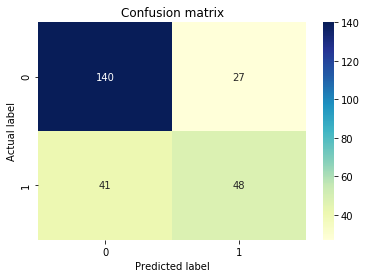

In [39]:
conf_matrix(skllog, X_test, y_test)

In [42]:
metric_report(skllog, X_test, y_test)

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       167
           1       0.64      0.54      0.59        89

    accuracy                           0.73       256
   macro avg       0.71      0.69      0.69       256
weighted avg       0.73      0.73      0.73       256



#### Моя логистическая регрессия

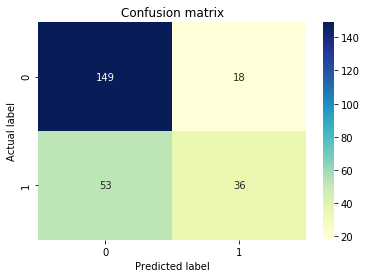

In [43]:
conf_matrix(mylog, X_test, y_test)

In [44]:
metric_report(mylog, X_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       167
           1       0.67      0.40      0.50        89

    accuracy                           0.72       256
   macro avg       0.70      0.65      0.66       256
weighted avg       0.71      0.72      0.70       256



#### sklearn метод k ближайших соседей

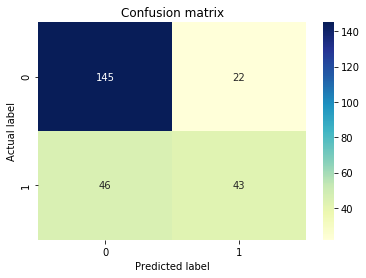

In [46]:
conf_matrix(sklknn, X_test, y_test)

In [45]:
metric_report(sklknn, X_test, y_test)

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       167
           1       0.66      0.48      0.56        89

    accuracy                           0.73       256
   macro avg       0.71      0.68      0.68       256
weighted avg       0.73      0.73      0.72       256



#### Мой метод k ближайших сосоедей

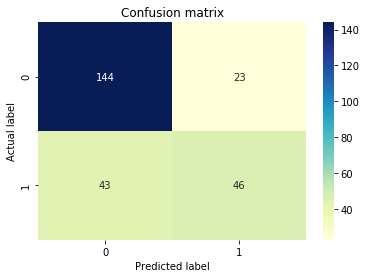

In [47]:
conf_matrix(myknn, X_test, y_test)

In [48]:
metric_report(myknn, X_test, y_test)

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       167
           1       0.67      0.52      0.58        89

    accuracy                           0.74       256
   macro avg       0.72      0.69      0.70       256
weighted avg       0.73      0.74      0.73       256



#### sklearn решающее дерево

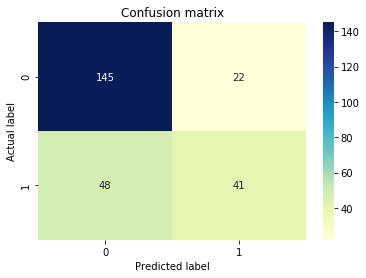

In [49]:
conf_matrix(skltree, X_test, y_test)

In [50]:
metric_report(skltree, X_test, y_test)

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       167
           1       0.65      0.46      0.54        89

    accuracy                           0.73       256
   macro avg       0.70      0.66      0.67       256
weighted avg       0.72      0.73      0.71       256



#### Мое решающее дерево

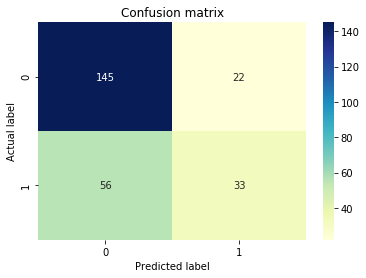

In [51]:
conf_matrix(mytree, X_test, y_test)

In [52]:
metric_report(mytree, X_test, y_test)

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       167
           1       0.60      0.37      0.46        89

    accuracy                           0.70       256
   macro avg       0.66      0.62      0.62       256
weighted avg       0.68      0.70      0.67       256



#### sklearn метод опорных векторов

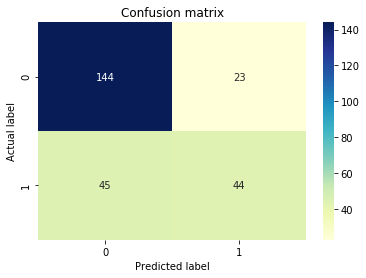

In [53]:
conf_matrix(sklsvm, X_test, y_test)

In [54]:
metric_report(sklsvm, X_test, y_test)

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       167
           1       0.66      0.49      0.56        89

    accuracy                           0.73       256
   macro avg       0.71      0.68      0.69       256
weighted avg       0.73      0.73      0.72       256



#### Мой вектор опорных векторов

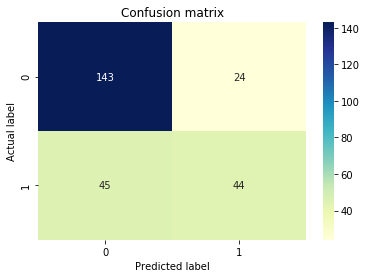

In [55]:
conf_matrix(mysvm, X_test, y_test)

In [56]:
metric_report(mysvm, X_test, y_test)

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       167
           1       0.65      0.49      0.56        89

    accuracy                           0.73       256
   macro avg       0.70      0.68      0.68       256
weighted avg       0.72      0.73      0.72       256



### Победитель

<span style="color:green"> Моя реализация метода k ближайших с расширением до метода окна Парзена с  трикубическим ядром.</span>

In [57]:
print("Best Accuracy:", myknn.score(X_test, y_test))
myknn

Best Accuracy: 0.7421875


KNN

### Проигравший

<span style="color:orange"> Моя реализация решающего дерева с прунингом. </span>

In [58]:
print("Worst Accuracy:", mytree.score(X_test, y_test))
mytree

Worst Accuracy: 0.6953125


Tree

## Вывод

Моя реализация *метода k ближайших соседей* дает результаты аналогичные sklearn реализации, однако мой класс метода позволяет расширить его до *метода окна Парзена*, что заставляет классификатор учитывать расстояния до объектов, что интуитивно считается более правильным. 

Мое решающее дерево без прунинга дает результат сопостовимый с профессиональной реализацией, однако наши реализации имеют разную чувствительность к параметру стрижки $\alpha$, из чего я делаю вывод, что возможно мне стоит перепроверить её реализацию.

Отмечу, что моя реализация *SVM* очень достойно выглядит с линейным ядром, однако попытка использовать *RBF* сильно замедлила процесс классификации и дала неприлично плохой результат, из чего я делаю вывод, что скорей всего мне следует переписать функцию ядра. Однако написать корректное ядро - не моя задача, а класс метода позволяет пользователю задвать свои ядра в щависимости от предпочтений.

Заметно, что решатель из профессиональной реализации, использующий метод спуска, основанный на *ньютоновских* методах, гораздо проще настраивается и находит лучший результат за приемлимое время.

В целом я доволен своими реализациями, поскольку они показали очень достойный результат классификации, имея незначительное отстование по времени.